<div><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/9120/logos/header.png?t=2018-04-02-23-51-59"></img></div>

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/9120/logos/thumb76_76.png?t=2018-04-02-23-45-04" align="left" width = "120px"/>

<h1 style="text-align: center;"> 기말 프로젝트 : <b>Home Credit Default Risk</b> 데이터 활용 </h1>
<h2 style="text-align: right;" >- 김이준</h2>

## EDA(Exploratory Data Analysis)

### - EDA(탐색적 자료 분석)

- 데이터를 다양한 각도에서 관찰하고, 데이터의 특징을 이해하기 위한 과정
        - 변수파악, 통계량산출, 상관분석, 데이터 시각화 등
        
        
- 그래프나 통계적 방법으로 자료를 직관적으로 파악하는 과정
        - 데이터가 가지고 있는 특성을 이해하고 잠재적인 문제 발견
        - 다양한 문제점을 발견하고, 이를 바탕으로 기존 가설 수정 또는 새로운 가설 수립

### Kaggle 기본 설정

In [ ]:
import numpy as np # numpy 임포트. linear algebra
import pandas as pd # pandas 임포트. data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt # 그래프 그리기 위해 matplotlib 임포트.
import seaborn as sns # 그래프 그리기 위해 seaborn 임포트.


# 존재하는 데이터들 PATH 출력하여 살펴보기.
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Data loader : 모든 데이터 읽어오기

In [ ]:
# pd.read_csv 로 모든 데이터 읽어오기.
application_train = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
application_test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')

# 아래 데이터들은 일단 아직 읽어오지 않고, 후에 필요한 데이터들만 따로 불러올 예정이다.
#POS_CASH_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv')
#bureau_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau_balance.csv')
#previous_application = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')
#credit_card_balance = pd.read_csv('/kaggle/input/home-credit-default-risk/credit_card_balance.csv')
#installments_payments = pd.read_csv('/kaggle/input/home-credit-default-risk/installments_payments.csv')
#bureau = pd.read_csv('/kaggle/input/home-credit-default-risk/bureau.csv')

#### Application_train 데이터 EDA 및 시각화

In [ ]:
#application_train 데이터 존재하는 컬럼 확인.
application_train.columns.values

In [ ]:
# TARGET 데이터에서 0은 282686개로, 전체의 약 91.92% 차지.
# TARGET 데이터에서 1은 24825개로, 전체의 약 8.07% 차지.
# 이를 통해 학습을 위한 데이터 Target값이 불균형함을 알 수 있음. (Imbalanced data)

print(application_train['TARGET'].value_counts())
print(application_train['TARGET'].value_counts()/application_train.shape[0])
application_train['TARGET'].astype(int).plot.hist();

In [ ]:
# 학습을 위한 application_train의 전체 컬럼 개수는 122개 이며, 이 중에서 결측치가 있는 컬럼 개수는 67개임을 알 수 있다.
# 데이터 row 는 총 307511개 존재함을 알 수 있다.

print("Dimension of application_train :", application_train.shape)
print("결측치가 있는 컬럼 수 :",(application_train.isnull().sum()!=0).sum())
application_train.head()

#### 결측치가 있는 row 삭제

In [ ]:
# 만약 train 데이터에서 결측치가 있는 row를 삭제한다면 307511개 중 8602개의 row, 즉 전체 데이터의 약 2.7%만 남게됌.
# 너무 적은 양의 데이터만 남기 때문에 결측치를 처리하는 다른 방법이 필요함.
# 그냥 임의의 값을 넣어 채우면 데이터 분석에 문제가 될 수 있음.

print("Dimension :", application_train.dropna(axis=0).shape)
print("결측치가 있는 컬럼 수 :",(application_train.dropna(axis=0).isnull().sum()!=0).sum())
application_train.dropna(axis=0)

In [ ]:
# 컬럼마다의 결측치의 수를 시각화.
# 특정 컬럼에서 결측치가 특히 많음을 알 수 있다.
column_series = application_train.isnull().sum()
print(column_series)
sns.histplot(column_series, kde=True)

In [ ]:
# 너무 결측치가 많은 column은 손실된 정보를 가지고 있어 잘 못 다루게되면 데이터 분석 결과에 안좋은 영향을 미칠 수도 있다.
# 때문에, 결측치가 너무 많은 컬럼을 제외하는 방법을 사용함.(100000개 이상 기준으로 threshold를 정함.)
# 이를 위해 먼저 결측치가 너무 많은 컬럼 이름들을 column_list에 저장한다.

column_list = []
for name in column_series.keys():
    if(column_series[name]>100000):
        column_list.append(name)

print(column_list, len(column_list))

In [ ]:
# 결측치가 많은 컬럼을 제거해도 결과값에 큰 영향을 미치지 않을지 Target값에 미치는 영향을 알아보도록 한다.

# 각 컬럼마다 target에 따른 데이터 비교 그래프를 시각화해서 보여주는 함수.
# 연속형 데이터 뿐만 아니라 str값을 데이터로 가지고 있는 categorical 데이터도 한 눈에 볼 수 있도록 했다.
# 왼쪽은 분포를 한 눈에 확인 할 수 있도록 violinplot과, barplot으로 분포 비율을 비교할 수 있도록 했다.
# 오른쪽은 전체적인 데이터 개수를 확인 할 수 있도록 histplot과 lineplot로 실제 개수를 비교할 수 있도록 했다.(파랑:target=0,빨강:target=1)

def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == 0)
    
    for column in columns:
        fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
        if(type(df[column][0]) is str):
            df_temp = df[["TARGET",column]].value_counts().astype(float)#
            idx_temp = df_temp.reset_index(name='RATIO')[column].unique()
            for i in range(0,2):
                sum_temp = df_temp[i].sum()
                for j in idx_temp:
                    df_temp[(i,j)] = df_temp[(i,j)] / sum_temp
            df_temp = df_temp.reset_index(name='RATIO')
                    
            sns.barplot(x="TARGET", y="RATIO", hue=column, data=df_temp,ax=ax[0][0])
            sns.lineplot(x=df[cond_1][column].value_counts().keys().tolist(), y=df[cond_1][column].value_counts(), label = 'target=1', color='red', ax=ax[0][1])#, kde=True)
            sns.lineplot(x=df[cond_0][column].value_counts().keys().tolist(), y=df[cond_0][column].value_counts(), label = 'target=0', color='blue', ax=ax[0][1])#, kde=True)
        else:
            sns.violinplot(x='TARGET', y=column, data=df, ax=ax[0][0])
            sns.histplot(df[cond_1][column], label='target=1', color='red', ax=ax[0][1], kde=True)
            sns.histplot(df[cond_0][column], label='target=0', color='blue', ax=ax[0][1], kde=True)
        plt.show()
        plt.close()

In [ ]:
# 결측치가 많은 데이터들의 Target값에 따른 데이터 비교 분석표

#show_hist_by_target(application_train, column_list)

결측치가 많은 데이터들의 분포 그래프를 분석해 보았을 때 직관적으로 차이가 있는 데이터는 EXT_SOURCE_1 가 있다.

직관적으로만 생각해보았을때, EXT_SOURCE_1 컬럼을 제거하지 않는 것이 데이터 분석에 유의미하다고 할 수 있다.

corr 함수를 이용해 상관관계를 도출하여 이를 뒷받침할 근거로 수치적인 데이터를 분석해보도록 한다.

In [ ]:
# 결측치가 많은 데이터들의 상관관계 분석
cor = application_train[column_list+["TARGET"]].corr()

# 클러스터맵 시각화
sns.clustermap(cor, 
#               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [ ]:
# 이 중 Target값과의 상관관계만 출력. 절대값을 씌워서 영향을 미치는 역순으로 나열함.
# 예상대로 EXT_SOURCE_1의 상관관계가 제일 큼을 확인함.

abs(cor["TARGET"]).sort_values()

## Feature Engineering

### Label Encoding

위에서의 상관관계를 볼 때, 범주형 데이터는 포함되지 않는 것을 확인할 수 있음.

때문에, 범주형 데이터의 상관관계도 확인할 수 있도록하는 방법 중 Label Encoding을 사용하기로 함.

먼저 train 데이터에서 범주형 컬럼을 확인함.

In [ ]:
# train 데이터의 dtypes 별 개수.
# 범주형 데이터(object) 컬럼의 개수가 16개 임을 알 수 있음.
application_train.dtypes.value_counts()

In [ ]:
# 범주형 데이터 컬럼 리스트 확인.
application_train.select_dtypes('object').columns

In [ ]:
# 범주형 데이터 컬럼마다 각 범주(category) 수를 확인해봄.
application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [ ]:
# Label Encoding 수행 전후 비교를 위해, 범주형 데이터인 FONDKAPREMONT_MODE 컬럼 값 확인
application_train["FONDKAPREMONT_MODE"]

In [ ]:
# Scikit-Learn 의 LabelEncoder 함수를 이용해서 train, test 데이터 Label Encoding.

from sklearn.preprocessing import LabelEncoder

# LabelEncoder()
le = LabelEncoder()
le_count = 0

# 전체 Iterate
for col in application_train:
    if application_train[col].dtype == 'object':
        # 범주가 2개 이상일 경우.
        if len(list(application_train[col].unique())) >= 2:
            # Train 데이터에 fit
            le.fit(application_train[col])
            # Train, Test 데이터 범주형 데이터 수치화.
            application_train[col] = le.transform(application_train[col])
            application_test[col] = le.transform(application_test[col])
            
            le_count += 1
            
print('Label Encoding : %d 컬럼 라벨 인코딩 완료.' % le_count)

In [ ]:
# 라벨 인코딩 수행 후 FONDKAPREMONT_MODE 컬럼 값 확인.
application_train["FONDKAPREMONT_MODE"]

In [ ]:
# 범주형 데이터 컬럼이 잘 처리되어 존재하지 않는것 확인.

application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

In [ ]:
# 결측치가 많던 컬럼들의 Target에 대한 상관관계 확인
abs(application_train[column_list+["TARGET"]].corr()["TARGET"]).sort_values()

In [ ]:
# 전체 컬럼들의 Target에 대한 상관관계 확인
rel = abs(application_train.corr()["TARGET"]).sort_values()
rel

In [ ]:
# 추가적으로 상관관계 낮은 데이터를 지우기 위한 작업 수행. 기준점(Threshold = 0.03)
# rel_list = Target과 상관관계가 0.03 이하인 컬럼이름 리스트

rel_list = []

for rel_column in rel.index:
    if(rel[rel_column]<0.03):
        rel_list.append(rel_column)
        print(rel_column)

In [ ]:
# SK_ID_CURR 은 고유번호이기에 지울 목록에서 제외시키도록 함.
rel_list.remove('SK_ID_CURR')

In [ ]:
column_list

In [ ]:
# column_list(결측치 많은 컬럼) 에서 상관관계가 높은 EXT_SOURCE_1을 보류하고,
# rel_list(상관관계가 0.03보다 작은 컬럼)
# train 데이터에서 위에서 만든 두 리스트 내의 컬럼들을 지운다.
# 그리고, 결측치가 있는 row를 제거 한다.

column_list.remove("EXT_SOURCE_1")
app_train = application_train#.drop(column_list + rel_list,axis=1).dropna(axis=0)

In [ ]:
# 위에서 사용한 방법으로 수정된 train 데이터 확인.
# 최종적으로 사용할 컬럼 수는 26개 + SK_ID_CURR + TARGET.
# 데이터 수는 109130개.

print("Dimension of app_train :", app_train.shape)
print("결측치가 있는 컬럼 수 :",(app_train.isnull().sum()!=0).sum())
app_train.head()

In [ ]:
# 마찬가지 방법으로 application_test의 전체 컬럼 개수는 121개(target column 제외) 이며, 이 중에서 결측치가 있는 컬럼 개수는 64개 
# 데이터 row 는 총 48744개 존재.

print("Dimension of application_test :", application_test.shape)
print("결측치가 있는 컬럼 수 :",(application_test.isnull().sum()!=0).sum())
application_test.head()

In [ ]:
app_test = application_test#.drop(column_list+rel_list,axis=1)

In [ ]:
# 마찬가지 방법으로 수정된 test 데이터 확인.
# 최종적으로 사용할 컬럼 수는 26개 + SK_ID_CURR.

print("Dimension of app_test :", app_test.shape)
print("결측치가 있는 컬럼 수 :",(app_test.isnull().sum()!=0).sum())
app_test.head()

### Advanced Feature Engineering

추가적으로 주어진 소스에서 사용한 Feature Engineering 들을 적용하기로 한다.

먼저, data_processing이라는 함수로 가공한다.

In [ ]:
def data_processing(out, data):
    
    # EXT_SOURCE_X FEATURE 가공
    out['APPS_EXT_SOURCE_MEAN'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    out['APPS_EXT_SOURCE_STD'] = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    out['APPS_EXT_SOURCE_STD'] = out['APPS_EXT_SOURCE_STD'].fillna(out['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    out['APPS_ANNUITY_CREDIT_RATIO'] = data['AMT_ANNUITY']/data['AMT_CREDIT']
    out['APPS_GOODS_CREDIT_RATIO'] = data['AMT_GOODS_PRICE']/data['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 대출 금액 관련 Feature 가공
    out['APPS_ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY']/data['AMT_INCOME_TOTAL']
    out['APPS_GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE']/data['AMT_INCOME_TOTAL']
    out['APPS_CREDIT_INCOME_RATIO'] = data['AMT_CREDIT']/data['AMT_INCOME_TOTAL']
    out['APPS_CNT_FAM_INCOME_RATIO'] = data['AMT_INCOME_TOTAL']/data['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득/자산 관련 Feature 가공
    out['APPS_EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    out['APPS_INCOME_EMPLOYED_RATIO'] = data['AMT_INCOME_TOTAL']/data['DAYS_EMPLOYED']
    out['APPS_INCOME_BIRTH_RATIO'] = data['AMT_INCOME_TOTAL']/data['DAYS_BIRTH']
    out['APPS_CAR_BIRTH_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_BIRTH']
    out['APPS_CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / data['DAYS_EMPLOYED']
    
    return out

In [ ]:
app_train.shape, app_test.shape

#### 새로운 Feature들을 만드는 data_processing 함수를 train, test 데이터에 적용.

In [ ]:
app_train = data_processing(app_train, application_train)
app_test = data_processing(app_test, application_test)
app_train.shape, app_test.shape

#### 이전 대출기록이 있는 데이터 불러오기

In [ ]:
prev_app = pd.read_csv('../input/home-credit-default-risk/previous_application.csv')
print(prev_app.shape, app_train.shape)

#### prev 피처 가공 / 대출 신청액 대비 다른 금액 차이 및 비율 생성

In [ ]:
prev_app['PREV_CREDIT_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_CREDIT']
prev_app['PREV_GOODS_DIFF'] = prev_app['AMT_APPLICATION'] - prev_app['AMT_GOODS_PRICE']
prev_app['PREV_CREDIT_APPL_RATIO'] = prev_app['AMT_CREDIT']/prev_app['AMT_APPLICATION']
prev_app['PREV_ANNUITY_APPL_RATIO'] = prev_app['AMT_ANNUITY']/prev_app['AMT_APPLICATION']
prev_app['PREV_GOODS_APPL_RATIO'] = prev_app['AMT_GOODS_PRICE']/prev_app['AMT_APPLICATION']

#### DAYS_XXX 피처의 365243 을 NULL로 변환하고, 첫번째 만기일과 마지막 만기일까지의 기간 가공

In [ ]:
prev_app['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev_app['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# 첫번째 만기일과 마지막 만기일까지의 기간
prev_app['PREV_DAYS_LAST_DUE_DIFF'] = prev_app['DAYS_LAST_DUE_1ST_VERSION'] - prev_app['DAYS_LAST_DUE']

In [ ]:
# PREV_INTERESTS_RATE Feature 가공
all_pay = prev_app['AMT_ANNUITY'] * prev_app['CNT_PAYMENT']
prev_app['PREV_INTERESTS_RATE'] = (all_pay/prev_app['AMT_CREDIT'] - 1)/prev_app['CNT_PAYMENT']
prev_app.shape

#### 기존 피처들과 이들을 가공하여 만들어진 새로운 컬럼들로 aggregation 수행

In [ ]:
agg_dict = {
     # 기존 컬럼. 
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    # 가공 컬럼
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],
    'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
    'PREV_INTERESTS_RATE':['mean', 'max']
}

prev_group = prev_app.groupby('SK_ID_CURR') # groupby 대상 컬럼명
prev_amt_agg = prev_group.agg(agg_dict)

# Multi Index 를 _로 이어진 문자열 Index 로 변경.
prev_amt_agg.columns = ['PREV_' + ('_').join(column).upper() for column in prev_amt_agg.columns.ravel()]

prev_amt_agg.head()

In [ ]:
app_train.shape

In [ ]:
prev_app_merge = app_train.merge(prev_amt_agg, on='SK_ID_CURR', how='left', indicator=True)
prev_app_merge = prev_app_merge.drop(columns=['_merge'])
prev_app_merge.shape

In [ ]:
prev_app_merge = prev_app_merge.replace(float("-inf"),0)
prev_app_merge.head()

#### 과거 대출 승인, 거절 내역을 이용한 Feature Enginerring

In [ ]:
prev_app['NAME_CONTRACT_STATUS'].value_counts()

In [ ]:
# 거절된 사례와 승인된 사례의 수를 세어서 Feature로 만든다.

cond_refused = (prev_app['NAME_CONTRACT_STATUS'] == 'Refused')
cond_approved = (prev_app['NAME_CONTRACT_STATUS'] == 'Approved')

prev_refused = prev_app[cond_refused]
prev_approved = prev_app[cond_approved]

prev_refused.shape, prev_approved.shape, prev_app.shape

In [ ]:
prev_refused = prev_refused.groupby('SK_ID_CURR')
prev_approved = prev_approved.groupby('SK_ID_CURR')

In [ ]:
prev_refused = prev_refused['NAME_CONTRACT_TYPE'].count()
prev_refused.name = "PRE_CONTRACT_REFUSED"
prev_approved = prev_approved['NAME_CONTRACT_TYPE'].count()
prev_approved.name = "PRE_CONTRACT_APPROVED"

In [ ]:
# Feature로 사용할 수 있도록 merge 해주고, 승인율, 거절율 같은 Feature도 만들어서 적용해보도록 한다.
prev_app_merge = prev_app_merge.merge(prev_approved, on='SK_ID_CURR', how='left', indicator=False)
prev_app_merge = prev_app_merge.merge(prev_refused, on='SK_ID_CURR', how='left', indicator=False)
prev_app_merge['PRE_CONTRACT_APPROVED_RATE'] = prev_app_merge['PRE_CONTRACT_APPROVED'] / ( prev_app_merge['PRE_CONTRACT_APPROVED'] + prev_app_merge['PRE_CONTRACT_REFUSED'] )
prev_app_merge['PRE_CONTRACT_REFUSED_RATE'] = prev_app_merge['PRE_CONTRACT_REFUSED'] / ( prev_app_merge['PRE_CONTRACT_APPROVED'] + prev_app_merge['PRE_CONTRACT_REFUSED'] )

prev_app_merge.head()

In [ ]:
# 0으로 나누어 생기는 NaN 값을 처리해준다.
prev_app_merge = prev_app_merge.replace(float('NaN'),0)
prev_app_merge.head()

### bureau 데이터 Feature Engineering

In [ ]:
bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
print("Size of bureau data", bureau.shape)

In [ ]:
# bureau 데이터를 확인
bureau.head()

In [ ]:
# 고객 당 과거 대출 수

PAST_LOANS_PER_CUS = bureau[['SK_ID_CURR', 'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index().rename(index=str, columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})
app_train_bureau = prev_app_merge.merge(PAST_LOANS_PER_CUS, on = ['SK_ID_CURR'], how = 'left')
print(app_train_bureau.shape)
app_train_bureau.head()

In [ ]:
# 고객 당 과거 대출 유형 수

BUREAU_LOAN_TYPES = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
app_train_bureau = app_train_bureau.merge(BUREAU_LOAN_TYPES, on = ['SK_ID_CURR'], how = 'left').fillna(0)
print(app_train_bureau.shape)
app_train_bureau.head()

In [ ]:
# 고객 당 유형별 평균 과거 대출 수 = 고객 당 과거 대출 수 / 고객 당 과거 대출 유형 수
# --> 고객이 다양한 유형의 대출을 받거나 단일 유형의 대출에 집중하고 있는지 확인가능

app_train_bureau['AVERAGE_LOAN_TYPE'] = app_train_bureau['BUREAU_LOAN_COUNT']/app_train_bureau['BUREAU_LOAN_TYPES']
app_train_bureau = app_train_bureau.fillna(0)
print(app_train_bureau.shape)
app_train_bureau.head()

In [ ]:
del app_train_bureau['BUREAU_LOAN_COUNT'], app_train_bureau['BUREAU_LOAN_TYPES']
app_train_bureau.head()

In [ ]:
def f(x):
    if x == 'Closed':
        y = 0
    else:
        y = 1    
    return y

bureau_fe1 = bureau
bureau_fe1['CREDIT_ACTIVE_CLOSED'] = bureau_fe1.apply(lambda x: f(x.CREDIT_ACTIVE), axis = 1)
bureau_fe1.head()

In [ ]:
# CUSTOMER 당 활성 상태인 평균 대출 수 계산
grp = bureau_fe1.groupby(by = ['SK_ID_CURR'])['CREDIT_ACTIVE_CLOSED'].mean().reset_index().rename(index=str, columns={'CREDIT_ACTIVE_CLOSED':'ACTIVE_LOANS_PERCENTAGE'})
app_train_bureau = app_train_bureau.merge(grp, on = ['SK_ID_CURR'], how = 'left')

# 중복된 컬럼 삭제
del bureau_fe1['CREDIT_ACTIVE_CLOSED']
print(bureau_fe1.shape)
bureau_fe1.head()

In [ ]:
app_train_bureau = app_train_bureau.fillna(0)
app_train_bureau.head()

In [ ]:
# bureau 채무 완료 날짜 및 대출 금액 대비 채무 금액 관련 피처 가공

# 예정 채무 시작 및 완료일과 실제 채무 완료일간의 차이 및 날짜 비율 가공.  
app_train_bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
app_train_bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
app_train_bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']

# 채무 금액 대비/대출 금액 비율 및 차이 가공
app_train_bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
app_train_bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

app_train_bureau = app_train_bureau.fillna(0)
app_train_bureau.head()

### Light GBM Classifier

In [ ]:
app_train = app_train_bureau

In [ ]:
# 학습시 사용할 train, test 데이터를 나눈다.
from sklearn.model_selection import train_test_split

ftr_app = app_train.drop(columns=['SK_ID_CURR','TARGET'])
target_app = app_train['TARGET']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

In [ ]:
# 베이지안 최적화를 통해서 LGBM Classifier를 파라미터를 조절하면서 여러번 돌려 성능을 최대한 높이도록 한다.

from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score

def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.reindex([train_index]), y_data.reindex([train_index])
        x_valid, y_valid = x_data.reindex([valid_index]), y_data.reindex([valid_index])
        
        model = LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            max_depth=16,
        )
        
        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= False, 
        early_stopping_rounds= 100)
        models.append(model)
        pred = model.predict_proba(valid_x)[:, 1]
        true = valid_y
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [ ]:
from functools import partial 

func_fixed = partial(lgb_cv, x_data=train_x, y_data=train_y, n_splits=5, output='score') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (16, 1024),      # n_estimators,     범위(16~1024)
        'subsample': (0, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0, 1),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0, 10),            # reg_alpha,        범위(0~10)
        'reg_lambda': (0, 50),           # reg_lambda,       범위(0~50)
    }, 
    random_state=2020                    # 시드 고정
)
lgbBO.maximize(init_points=5, n_iter=10) # 처음 5회 랜덤 값으로 score 계산 후 30회 최적화

In [ ]:
# 제일 성능이 높았던 파라미터를 가져온다.
lgbBO.max['params']

In [ ]:
clf = LGBMClassifier(
    n_estimators=int(lgbBO.max['params']['n_estimators']),
    learning_rate=lgbBO.max['params']['learning_rate'],
    num_leaves=int(lgbBO.max['params']['num_leaves']),
    subsample=lgbBO.max['params']['subsample'],
    max_depth=16,
    reg_alpha=lgbBO.max['params']['reg_alpha'],
    reg_lambda=lgbBO.max['params']['reg_lambda'])

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'auc', verbose= 100, 
        early_stopping_rounds= 200)

In [ ]:
# 해당 모델의 Feature Importance를 확인해보자.

from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

In [ ]:
# 실제 test 값도 train과 같은 Feature Engineering 데이터 처리를 해주어 LGBM 모델에 돌릴 수 있도록 한다.

test_merge = app_test.merge(prev_amt_agg, on='SK_ID_CURR', how='left', indicator=False)

test_merge = test_merge.merge(prev_approved, on='SK_ID_CURR', how='left', indicator=False)
test_merge = test_merge.merge(prev_refused, on='SK_ID_CURR', how='left', indicator=False)

test_merge['PRE_CONTRACT_APPROVED_RATE'] = test_merge['PRE_CONTRACT_APPROVED'] / ( test_merge['PRE_CONTRACT_APPROVED'] + test_merge['PRE_CONTRACT_REFUSED'] )
test_merge['PRE_CONTRACT_REFUSED_RATE'] = test_merge['PRE_CONTRACT_REFUSED'] / ( test_merge['PRE_CONTRACT_APPROVED'] + test_merge['PRE_CONTRACT_REFUSED'] )
test_merge = test_merge.replace(float('NaN'),0)

test_merge = test_merge.merge(PAST_LOANS_PER_CUS, on = ['SK_ID_CURR'], how = 'left')
test_merge = test_merge.merge(BUREAU_LOAN_TYPES, on = ['SK_ID_CURR'], how = 'left').fillna(0)
test_merge['AVERAGE_LOAN_TYPE'] = test_merge['BUREAU_LOAN_COUNT']/test_merge['BUREAU_LOAN_TYPES']
test_merge = test_merge.fillna(0)
del test_merge['BUREAU_LOAN_COUNT'], test_merge['BUREAU_LOAN_TYPES']
test_merge = test_merge.merge(grp, on = ['SK_ID_CURR'], how = 'left').fillna(0)

test_merge['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
test_merge['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
test_merge['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']

test_merge['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']
test_merge['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']

test_merge = test_merge.fillna(0)


preds = clf.predict_proba(test_merge.drop(columns=['SK_ID_CURR']))[:, 1]
app_test['TARGET'] = preds
app_test[['SK_ID_CURR', 'TARGET']].to_csv('result_00.csv', index=False)

Feature Engineering

시도해본 방법들 요약

1. 결측치가 많은 데이터 column & row 적절히 제거. (성능이 낮아져서 주석 처리함.)
2. previous_application.csv 이전 대출 기록 사용 (과거 대출 승인, 거절 내역 외 등등)
3. bureau.csv 과거 대출 기록 사용 (대출 금액 대비 채무 금액 관련 피처 외 등등) (성능이 크게 향상되지 않음.)
4. 베이지안 최적화를 통해서 LightGBM Classifier 파라미터 최적화

최종적으로 2,4번으로 Public Score 0.77289 달성.

1,3 방법을 같이 사용해도 최고 성능을 넘지 못하여 2,4번만 적용해 진행한 결과물을 최종제출하였다.

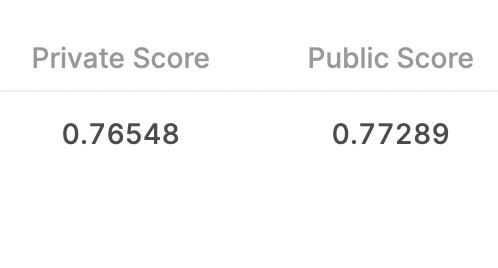